In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import f_classif, SelectFpr

# loading normalized dataset
samples = pd.read_csv('normalized_samples_nsclc.csv', index_col = 0).T
info = pd.read_csv('info.csv', sep = ';', index_col = 13)

X = samples.copy()
y = info[['Classification group']].copy().reindex(X.index)

# 25% of dataset was set for evaluation
sets = train_test_split(X, y, test_size = 0.25, random_state = 107)
X_train_not_scaled, X_test_not_scaled, y_train, y_test = sets

# scaling data, selection, encoding labels
sclr = RobustScaler()
X_train = sclr.fit_transform(X_train_not_scaled)

lbl = LabelEncoder()
y_train = lbl.fit_transform(y_train)

dge = SelectFpr(f_classif, alpha = 0.05)
X_train_r = dge.fit_transform(X_train, y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


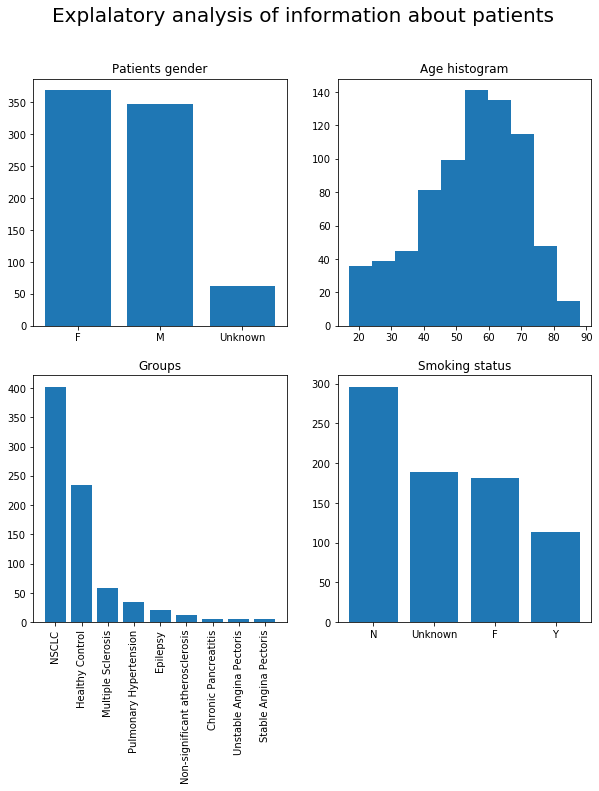

In [46]:
# Explalatory analysis of information about patients

fig, (ax1, ax2) = plt.subplots(2,2, figsize = (10,10))
fig.suptitle('Explalatory analysis of information about patients', fontsize = 20)

x = info['Gender'].fillna('Unknown').value_counts().index
h = info['Gender'].fillna('Unknown').value_counts()
ax1[0].bar(x, h)
ax1[0].set_title('Patients gender', fontsize = 12)

ax1[1].hist(info['Age'])
ax1[1].set_title('Age histogram', fontsize = 12)

x = info['Patient group'].fillna('Unknown').value_counts().index
h = info['Patient group'].fillna('Unknown').value_counts()
ax2[0].bar(x, h)
ax2[0].set_xticklabels(x, rotation = 90)
ax2[0].set_title('Groups', fontsize = 12)

x = info['Smoking'].fillna('Unknown').value_counts().index
h = info['Smoking'].fillna('Unknown').value_counts()
ax2[1].bar(x, h)
ax2[1].set_title('Smoking status', fontsize = 12)

plt.show()

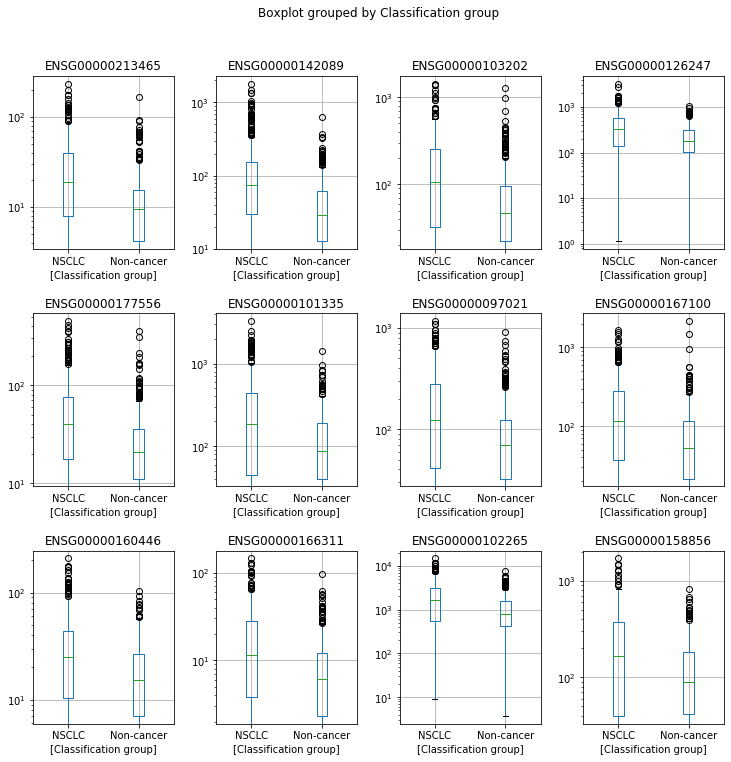

In [47]:
# boxplots of 12 most different genes between NSCLC and non-cancer groups
# differences were defined by previosly performed ANOVA pre-seletion

indieces = pd.Series(dge.pvalues_).sort_values().index

fig, axs = plt.subplots(3,4, figsize = (12,12))
i = 0
for row in axs:
    for ax in row:
        temp = pd.DataFrame(X).iloc[:,[indieces[i]]].copy()
        temp1 = temp.join(y)
        temp1.boxplot(by = 'Classification group', ax = ax, meanline = True)
        ax.set_yscale('log')
        i += 1
        
fig.subplots_adjust(hspace = 0.37, wspace = 0.3)
fig.patch.set_facecolor('white')

In [ ]:
from sklearn.decomposition import PCA
from sklearn.svm import LinearSVC
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline
from scipy.stats import randint, loguniform

n_c_distr = randint(4, 100)
tol_distr = loguniform(a = 1e-5, b = 1, loc = 0, scale = 3)
c_distr = loguniform(a = 1e-5, b = 1, loc = 0, scale = 3)
alpha_distr = loguniform(a = 1e-2, b = 1, loc = 0, scale = 1)

search_params = [{'dge__alpha': alpha_distr, 'pca__n_components': n_c_distr,
                  'pca__svd_solver': ['randomized', 'arpack', 'full'],
                  'clf__tol': tol_distr, 'clf__C': c_distr,
                  'clf__loss': ['hinge', 'squared_hinge']}]

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


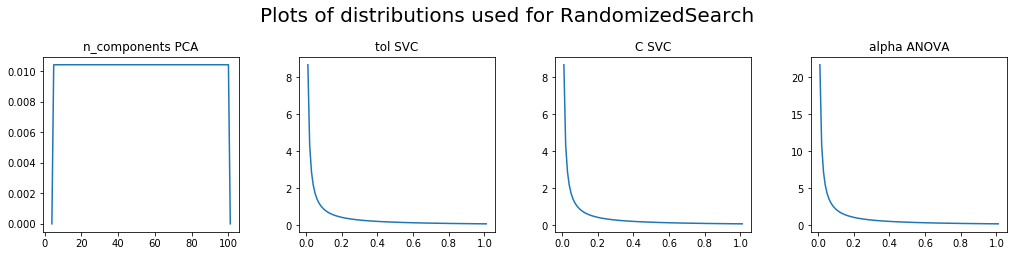

In [30]:
# visualization of numeric parameter distributions

import numpy as np

fig, axs = plt.subplots(1,4, figsize= (15, 4))

fig.suptitle('Plots of distributions used for RandomizedSearchCV', fontsize = 20)


axs[0].plot(np.linspace(4,101, num = 98), n_c_distr.pmf([x for x in range(3,101)]))
axs[0].set_title('n_components PCA')
axs[1].plot(np.linspace(0.01, 1.01, num = 100), tol_distr.pdf([x/100 + 0.01 for x in range(100)]))
axs[1].set_title('tol SVC')
axs[2].plot(np.linspace(0.01, 1.01, num = 100), c_distr.pdf([x/100 + 0.01 for x in range(100)]))
axs[2].set_title('C SVC')
axs[3].plot(np.linspace(0.01, 1.01, num = 100), alpha_distr.pdf([x/100 + 0.01 for x in range(100)]))
axs[3].set_title('alpha ANOVA')

fig.tight_layout(pad = 4)
fig.show()

In [6]:
# performing parameter hyperspace search
# 1800 configurations where checked on 3-fold cross-validation
# model with the highest AUC socre was chosen 

pca = PCA()
clf = LinearSVC()

pca_svd = Pipeline([('dge', dge), ('pca', pca), ('clf', clf)])

s_pca_svd = RandomizedSearchCV(pca_svd, search_params, cv = 3,
                               n_iter = 1800, n_jobs = 5,
                               verbose = 0, scoring = 'roc_auc')

s_pca_svd.fit(X_train, y_train)

#best_pca_svd = s_pca_svd.best_estimator_
display(pd.DataFrame(s_pca_svd.cv_results_).sort_values(['rank_test_score']).head())

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf__C,param_clf__loss,param_clf__tol,param_dge__alpha,param_pca__n_components,param_pca__svd_solver,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
1,0.633884,0.085766,0.028002,0.000811,0.02451,hinge,1.092191,0.015407,87,arpack,"{'clf__C': 0.024509548304990126, 'clf__loss': ...",0.901855,0.913557,0.913446,0.909619,0.005490,1
206,0.725314,0.032853,0.024333,0.002870,0.001331,squared_hinge,0.013664,0.043868,95,arpack,"{'clf__C': 0.0013313616986190071, 'clf__loss':...",0.902488,0.903542,0.920473,0.908834,0.008241,2
54,1.213780,0.075933,0.033023,0.003546,0.001078,squared_hinge,1.399439,0.047072,99,full,"{'clf__C': 0.0010782289939807901, 'clf__loss':...",0.902066,0.900590,0.921537,0.908065,0.009546,3
172,1.216861,0.044133,0.041847,0.005069,0.000735,squared_hinge,0.032014,0.217453,97,arpack,"{'clf__C': 0.0007346506562614676, 'clf__loss':...",0.905650,0.894265,0.923986,0.907967,0.012244,4
184,0.780557,0.089310,0.027029,0.004946,0.009331,squared_hinge,0.00609,0.017265,89,full,"{'clf__C': 0.00933126840870977, 'clf__loss': '...",0.899958,0.909445,0.913553,0.907652,0.005693,5


In [32]:
# saving and loading model from file

from joblib import dump, load

#dump(best_pca_svd, 'best_pca_svd.joblib')
#best_pca_svd = load('best_pca_svd.joblib')

In [36]:
# Validation was performed on the 25% of the dataset
# that was NOT in the training part of the dataset

from sklearn.metrics._plot.base import _get_response
from sklearn.metrics import plot_confusion_matrix, roc_curve, accuracy_score, roc_auc_score, auc
from sklearn.pipeline import Pipeline


y_test_encoded = lbl.transform(y_test)

full_pipeline = Pipeline([('sclr', sclr),
                          ('pca_svd', best_pca_svd)])

y_pred = full_pipeline.predict(X_test_not_scaled)
y_pred_proba = _get_response(X_test_not_scaled, full_pipeline, 'auto', 1)[0]

acc1 = round(accuracy_score(y_test_encoded, y_pred), 3)
auc1 = round(roc_auc_score(y_test_encoded, y_pred_proba), 3)

print(f'Test set accuracy: {acc1}\nTest set AUC: {auc1}')

Test set accuracy: 0.872
Test set AUC: 0.936


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


In [37]:
# defining random classifier that will predict outcome randomly, but stratified
# the goal was comparion of our classifier to random chance

from sklearn.dummy import DummyClassifier

dc = DummyClassifier('stratified', random_state = 304)
dc.fit(X_train_not_scaled, y_train)

y_pred_dc = dc.predict(X_test_not_scaled)
y_pred_proba_dc = dc.predict_proba(X_test_not_scaled)

acc_dc = round(accuracy_score(y_test_encoded, y_pred_dc), 3)
auc_dc = round(roc_auc_score(y_test_encoded, y_pred_proba_dc[:,1]), 3)

print(f'Test set accuracy: {acc_dc}\nTest set AUC: {auc_dc}')

Test set accuracy: 0.492
Test set AUC: 0.493


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass strategy=stratified as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


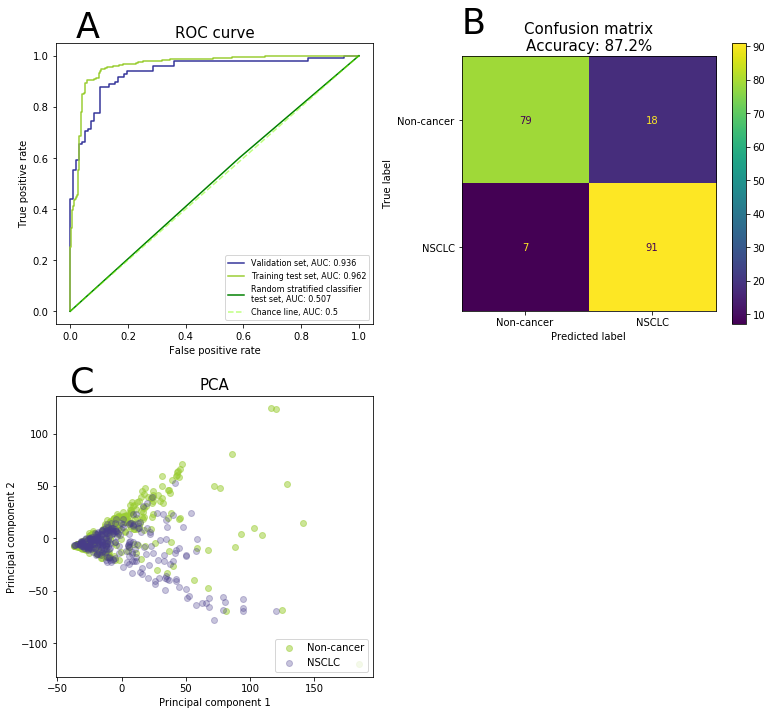

In [40]:
# rendering figures used in the manusript
# ROC curve, confusin matrix, scatterplot of PCA 1st and 2nd components

from sklearn.metrics._plot.base import _get_response
fig, (axs, axs1) = plt.subplots(2, 2, figsize = (11, 10))

y_pred_proba = _get_response(X_test_not_scaled, full_pipeline, 'auto', 1)[0]
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_pred_proba)
lbl = f'Validation set, AUC: {round(auc(fpr, tpr), 3)}'
axs[0].plot(fpr, tpr, label = lbl, color = 'navy', alpha = 0.8)

y_pred_proba_1 = _get_response(X_train_not_scaled, full_pipeline, 'auto', 1)[0]
fpr, tpr, thresholds = roc_curve(y_train, y_pred_proba_1)
axs[0].plot(fpr, tpr, label=f'Training test set, AUC: {round(auc(fpr, tpr), 3)}', color = 'yellowgreen')

fpr, tpr, thresholds = roc_curve(y_test_encoded, dc.predict_proba(X_test_not_scaled)[:,0])
lbl = f'Random stratified classifier\ntest set, AUC: {round(auc(fpr, tpr), 3)}'
axs[0].plot(fpr, tpr, label=lbl, color = 'green')

axs[0].plot([0,1],[0,1], '--', color = 'chartreuse', alpha = 0.5, label = 'Chance line, AUC: 0.5')

axs[0].text(0.02, 1.07, 'A', fontsize = 35)

axs[0].set_ylabel('True positive rate')
axs[0].set_xlabel('False positive rate')
axs[0].legend(fontsize = 8)
axs[0].set_title('ROC curve', fontsize = 15)

class_names = ['Non-cancer', 'NSCLC']
plot_confusion_matrix(full_pipeline, X_test_not_scaled, y_test_encoded,
                      ax = axs[1], display_labels = class_names, xticks_rotation = 0)
axs[1].set_title(f'Confusion matrix\nAccuracy: {acc1*100}%', fontsize = 15)
axs[1].text(-0.5, -0.68, 'B', fontsize = 35)

X_train_r = best_pca_svd.named_steps['dge'].transform(X_train)
X_train_r_decomp = best_pca_svd.named_steps['pca'].transform(X_train_r)

NC = [X_train_r_decomp[y_train == 0, 0], X_train_r_decomp[y_train == 0, 1]]
LC = [X_train_r_decomp[y_train == 1, 0], X_train_r_decomp[y_train == 1, 1]]

axs1[0].scatter(NC[0], NC[1], alpha = 0.5, label = 'Non-cancer', color = 'yellowgreen')
axs1[0].scatter(LC[0], LC[1], alpha = 0.3, label = 'NSCLC', color = 'darkslateblue')
axs1[0].set_title('PCA', fontsize = 15)
axs1[0].set_xlabel('Principal component 1')
axs1[0].set_ylabel('Principal component 2')
axs1[0].legend(loc = 'lower right')
axs1[0].text(-40, 140, 'C', fontsize = 35)

axs1[1].set_visible(False)

fig.tight_layout(pad = 1)